# Cell counter 
***Подсчёт всех клеток на фотографии препарата***

Для начала работы следует импортировать библиотеки: 

In [1]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

Загружаем фотографию и создаём её копию:

*(По умолчанию opencv воспринимает изображения в формате BGR, чтобы отобразить изображение в нормальных цветах, нужно конвентрировать BGR в RGB.)*

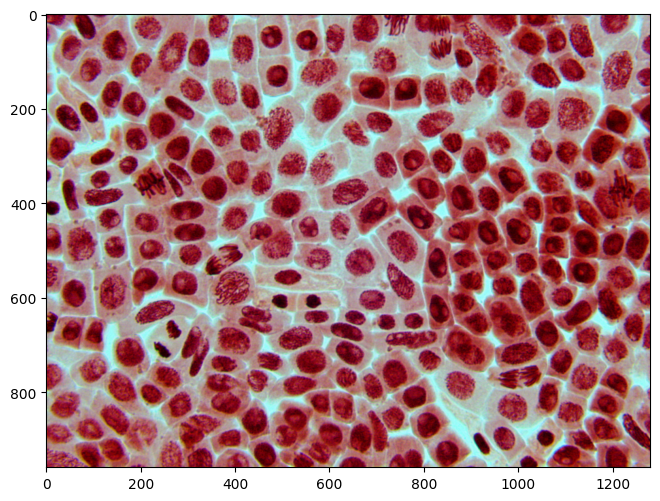

In [2]:
image = cv2.imread("6.jpg")
original = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(original)
plt.show()

Создаём изображение в формате HSV *(Hue, Saturation, Value — тон, насыщенность, яркость)*:

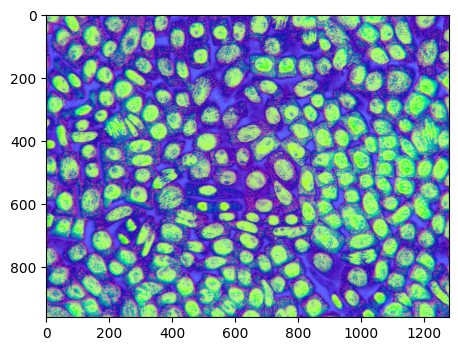

In [3]:
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 4), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(hsv)
plt.show()

### Создаём маску

Зададим границы цветов интересующих нас объектов **hsv_lower** и **hsv_upper** в диапозонах (0-180, 0-255, 0-255), чтобы создать 
маску-фильтр, которая отсекает все пиксели другого цвета.

<img src="https://i.stack.imgur.com/gyuw4.png" alt="hsv color map" title="color map"/>

Так как клетки лежат плотно друг к другу, если мы задади все красные тона (от 0 до 20 + от 140 до 180), всё сольется в одно большое пятно. Поэтому будем отбирать только ядра клеток, опытным путем можно найти, что их цыетовой тон соответствует значениям от 140 до 180 (розовые тона на картинке выше). 

*(Для других изображений препаратов иногда нужно изменить значение насыщенности **S** для нижней границы **hsv_lower = np.array([H,S,V])**), так как некоторые препараты окрашены менее ярко, а некоторые более ярко, чем тот, что в примере.*  

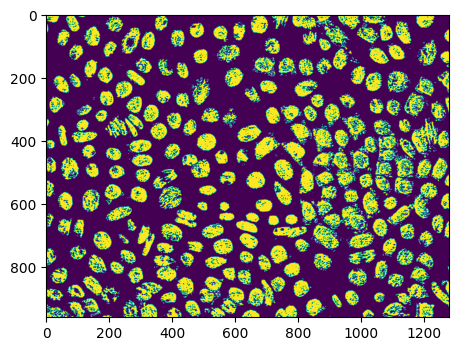

In [4]:
hsv_lower = np.array([140,140,0])
hsv_upper = np.array([180,255,255])
mask = cv2.inRange(hsv, hsv_lower, hsv_upper)
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 4), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(mask)
plt.show()

### Фильтрация изображения

Kernel - структурирующий элемент для морфологических операций. С помощью **cv2.MORF_OPEN** и **cv2.MORF_CLOSE** удалим шум *вокруг* и *внутри* ядер. Параметр **iterations** позволяет установить силу воздействия.

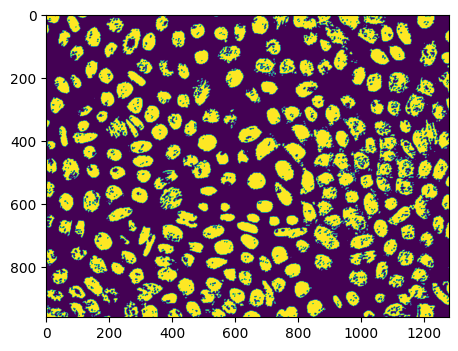

In [5]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))

opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
close = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=2)
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 4), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(close)
plt.show()

### Ищем контуры ядер

**findContours** *( кадр, режим_группировки, метод_упаковки)*

- **CV2.RETR_EXTERNAL** - режим поиска: найти только крайние внешние контуры;

- **CV_CHAIN_APPROX_SIMPLE** - метод апроксимации: сжимает горизонтальные, вертикальные и диагональные сегменты и оставляет только их конечные точки.

In [6]:
cnts = cv2.findContours(close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

Теперь у нас есть список контуров, внутри которых можно измерить площадь.

Зададим минимульную, среднюю и максимальную площад клетки:

In [7]:
minimum_area = 500
average_cell_area = 1500
connected_cell_area = 3000

Заведём два счётчика и пройдёмся циклом по всем контурам:
Если площадь внутри отдельного контура больше, чем **connected_cell_area**, то делим эту площадь на среднюю площадь (*average_cell_area*).

In [8]:
cells = 0
conn_cells=0
for c in cnts:
    area = cv2.contourArea(c)
    if area > minimum_area:
        if area > connected_cell_area:
            cv2.drawContours(original, [c], -1, (0,0,0), 2)
            M = cv2.moments(c)
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.putText(original, str(int(math.floor(area / average_cell_area))), (cX - 10, cY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 4)            
            conn_cells+=math.floor(area / average_cell_area)
        else: 
            cv2.drawContours(original, [c], -1, (100,255,12), 2)         
            cells+=1


Cells: 222
Connected cells: 20


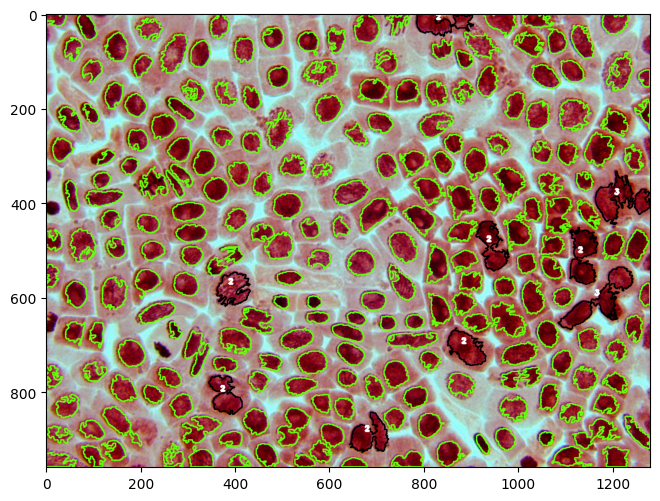

In [9]:
print('Cells: {}'.format(cells))
print('Connected cells: {}'.format(conn_cells))
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(original)
plt.show()

- *Одиночные клетки выделены зеленым цветом, если две соседние зеленые клетки явно перетекают друг в друга, то значит их общей площади не хватило, чтобы быть отнесенными к **Connected cells**, и они были посчитанны за одну.*
- *Черным выделены клетки,которые были добавлены в счётчик **Connected cells**,белая цифра внутри отображает, насчитанное количество клеток в такой области.*